##3.3 Creating a BRDF model

In [14]:
import os
import numpy as np
import itertools
import multiprocessing
import ctypes
from run_start import *
from hips2img import *
from plot_polar_contour import *
%matplotlib inline

##Method

The <code><span style="background-color:lightgrey">brdf_camera.dat</span></code> file has been updated to allow for text substitution, this is used to create a temporary <code><span style="background-color:lightgrey">camera.dat</span></code> with every iteration.

The azimuth and zenith angles in <code><span style="background-color:lightgrey">brdf_light.dat</span></code> have been changed to 90$^{\circ}$ and 75$^{\circ}$ repsectively.

In [23]:
azimuth = np.arange(0, 370, 10)
zenith = -np.arange(-60, 0, 5)
coordinates = np.asarray(list(itertools.product(azimuth, zenith)))

In [24]:
# http://stackoverflow.com/questions/5549190/is-shared-readonly-data-copied-to-different-processes-for-python-multiprocessing/5550156#5550156

shared_array_base = multiprocessing.Array(ctypes.c_double, len(coordinates) * 3)
shared_array = np.ctypeslib.as_array(shared_array_base.get_obj())
shared_array = shared_array.reshape(len(coordinates), 3)

shared_array[:, :2] = coordinates

def process_(i, def_param=shared_array):
    
    A = shared_array[i, 0]
    Z = shared_array[i, 1]
    
    # create tmeporary camera file
    camera_temp = open('camera/brdf_camera.dat').read()
    with open('camera/brdf_camera.{}.temp.dat'.format(i), 'w') as o:
        o.write(camera_temp % {'azi':A, 'zen':Z, 'res':'"output/brdf.{}"'.format(i)})

    # run simulation
    cmd = "echo 14 camera/brdf_camera.{}.temp.dat light/brdf_light.dat | \
           start -RATm 5 -RATsensor_wavebands wb/brdf_waveband.dat \
           obj/birch_tree_scene.obj".format(i)
    error = run_start(cmd)

    # extract reflectance value
    shared_array[i, 2] = np.loadtxt('output/brdf.{}.direct'.format(i))[:, 1].sum()
    
    # delete files
    os.unlink('output/brdf.{}.direct'.format(i))
    os.unlink('camera/brdf_camera.{}.temp.dat'.format(i))

if __name__ == '__main__':
    
    number_of_processes = 4
    estimated_time = (len(shared_array) / number_of_processes) / 60.
    
    print 'this will run {} tasks'.format(len(shared_array))
    print 'as each run takes ~1 min (on my mac) therefore whole process should take {:.2f} hours'.format(estimated_time)

    pool = multiprocessing.Pool(processes=number_of_processes)
    pool.map(process_, [i for i in range(len(shared_array))])

this will run 444 tasks
as each run takes ~1 min (on my mac) therefore whole process should take 1.85 hours


In [25]:
brdf_array = shared_array[:, 2].reshape(len(azimuth), len(zenith))

In [26]:
# shared_array = np.load('/Users/phil/Dropbox/RMIT/ipython/librat/output/shared_array.npy')
114 / 60.

1.9

(<matplotlib.figure.Figure at 0x10e458950>,
 <matplotlib.contour.QuadContourSet instance at 0x10e46f710>)

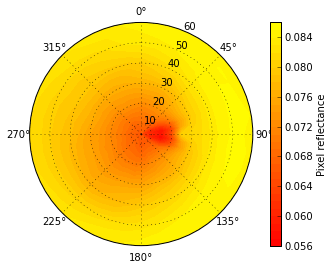

In [27]:
plot_polar_contour(brdf_array, azimuth, zenith)

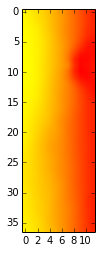

In [22]:
plt.imshow(brdf_array)